In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict
import shutil

In [2]:
print(pickle.HIGHEST_PROTOCOL)

5


In [3]:
def find_det_coordinates(spec):
    spec = spec-5
    x_before = spec//128
    y_before = spec%128
    y_new = 127-y_before
    x_new = 152*(x_before//152) + 151 - (x_before % 152)
    return int(y_new), int(x_new) # swapped to match x,y

In [4]:
def findSpectrumIndex(indices, ntubes=1520, npix_per_tube=128, ntubes_per_bank=152, nmonitors=5):
    """
    :param indices: indices of found peaks in 3d array
    :param ntubes: number of tubes in instrument (WISH)
    :param npix_per_tube: number of detector pixels in each tube
    :param ntubes_per_bank: number of tubes per bank
    :param nmonitors: number of monitor spectra (assumed first spectra in ws)
    :return: list of spectrum indindices of workspace corresponding to indices of found peaks in 3d array
    """
    # find bank and then reverse order of tubes in bank
    ibank = np.floor(indices[:,0]/ntubes_per_bank)
    itube = ibank*ntubes_per_bank + ((ntubes_per_bank-1) - indices[:,0] % ntubes_per_bank)
    # flip tube 
    ipix = (npix_per_tube-1) - indices[:,1]
    # get spectrum index
    specIndex = np.ravel_multi_index((itube.astype(int), ipix), 
        dims=(ntubes, npix_per_tube), order='C') + nmonitors
    return specIndex.tolist()  # so elements are of type int not numpy.int32

In [5]:
def get_bins_with_peaks(labels):
    peaks_per_bin = defaultdict(list)
    for spec, bin, _, _ in labels:
        if bin in peaks_per_bin:
            if spec not in peaks_per_bin[bin]:
                peaks_per_bin[bin].append(spec)
        else:
            peaks_per_bin[bin] = [spec]
    return peaks_per_bin

In [6]:
def get_bins_with_peaks_in_full_range(ws, labels):
    """
    Consider the bins from start to end for each peak as having a peak
    """
    peaks_per_bin = defaultdict(list)
    for i_bin in range(ws.shape[2]):
        for spec, max, start, end in labels:
            if i_bin >= start and i_bin <= end:
                if i_bin in peaks_per_bin:
                    if spec not in peaks_per_bin[i_bin]:
                        peaks_per_bin[i_bin].append(spec)
                else:
                    peaks_per_bin[i_bin] = [spec]
    return peaks_per_bin

In [7]:
def save_bins_with_annotations(labels, ws, annotation_outdir, nparr_outdir, ws_index):
    # peaks_per_bin = get_bins_with_peaks(labels)
    
    peaks_per_bin = get_bins_with_peaks_in_full_range(ws, labels)
    
    bin_index = 0
    for bin, peaks in peaks_per_bin.items():
        bin_save_path = os.path.join(nparr_outdir, f"{ws_index}_{bin_index}.npz")
        np.savez_compressed(bin_save_path, ws[:,:,bin])
        annotation_data = dict()
        annotation_data["nparr_path"] = bin_save_path
        annotation_data["bin_index"] = bin
        annotation_data["peaks"] = peaks
        annotation_save_path = os.path.join(annotation_outdir, f"annot_{ws_index}_{bin_index}.pickle")
        with open(annotation_save_path, 'wb') as handle:
            pickle.dump(annotation_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        bin_index += 1

In [8]:
workspaces_dir = "/home/wj1132075/Desktop/Raw_Data/Workspaces/"
labels_dir = "/home/wj1132075/Desktop/Raw_Data/Labels/"

In [9]:
annotations_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/Annotations/"
frames_output_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/"

### Create Annotation files and save bin data

In [10]:
shutil.rmtree(annotations_output_dir), shutil.rmtree(frames_output_dir)
os.mkdir(annotations_output_dir), os.mkdir(frames_output_dir)

(None, None)

In [11]:
def _add_peaks(peak_data, det_y, det_x, start, peak, end):
    if det_y in peak_data:
        peak_data[det_y].append((det_x, start, peak, end))
    else:
        peak_data[det_y] = [(det_x, start, peak, end)]
            
def save_tube_frames_with_annotations(labels, ws, annotation_outdir, frames_dir, ws_index):
    peak_data = defaultdict(list)
    for spec, peak, start, end in labels:
        det_x, det_y = find_det_coordinates(spec)
        _add_peaks(peak_data, det_y, det_x, start, peak, end)
        
        for neigh_spec, neigh_peak, neigh_start, neigh_end in labels:
            if neigh_spec == spec and peak == neigh_peak:
                continue
            neigh_x, neigh_y = find_det_coordinates(neigh_spec)
            if neigh_y in range(det_y-1, det_y+2):
                # print(f"adding neighbour{neigh_y, neigh_x, neigh_peak, neigh_start, neigh_end} for {det_y, det_x, peak, start, end}")
                _add_peaks(peak_data, det_y, neigh_x, neigh_start, neigh_peak, neigh_end)

    frame_index = 0
    for frame, peak_list in peak_data.items():
        frame_save_path = os.path.join(frames_dir, f"{ws_index}_{frame_index}.npz")
        np.savez_compressed(frame_save_path, ws[frame,:,:])
        annotation_data = dict()
        annotation_data["nparr_path"] = frame_save_path
        annotation_data["peaks"] = peak_list
        annotation_data["tube"] = frame
        annotation_save_path = os.path.join(annotation_outdir, f"annot_{ws_index}_{frame_index}.pickle")
        with open(annotation_save_path, 'wb') as handle:
            pickle.dump(annotation_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        frame_index += 1    

In [12]:
from tqdm.notebook import tqdm

for label_f_name in tqdm(sorted(os.listdir(labels_dir))):
    ws_index = label_f_name.split('.')[0].split('_')[-1]
    label_f_path = os.path.join(labels_dir, label_f_name)
    labels = np.loadtxt(label_f_path, delimiter=',', dtype=int)
    ws_f_name = f"workspace_{label_f_name.split('.')[0].split('_')[-1]}.npz"
    ws_f_path = os.path.join(workspaces_dir, ws_f_name)
    ws = np.load(ws_f_path)['arr_0']
    save_tube_frames_with_annotations(labels, ws, annotations_output_dir, frames_output_dir, ws_index)

  0%|          | 0/72 [00:00<?, ?it/s]

In [13]:
len(os.listdir(annotations_output_dir))

3131

### Do some Analysis on data

  0%|          | 0/3131 [00:00<?, ?it/s]

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/55_33.npz', 'peaks': [(17, 595, 596, 599)], 'tube': 1218}


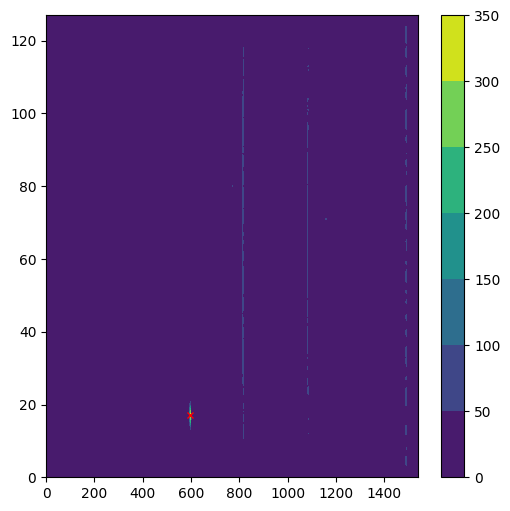

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/65_39.npz', 'peaks': [(107, 1145, 1145, 1149), (32, 1150, 1151, 1154), (32, 783, 784, 788), (70, 783, 784, 788), (107, 778, 779, 783), (32, 569, 569, 572), (57, 569, 570, 572), (82, 567, 568, 570), (107, 563, 564, 566), (70, 783, 784, 788), (32, 1150, 1151, 1154), (107, 1145, 1145, 1149), (32, 783, 784, 788), (107, 778, 779, 783), (32, 569, 569, 572), (57, 569, 570, 572), (82, 567, 568, 570), (107, 563, 564, 566), (107, 778, 779, 783), (32, 1150, 1151, 1154), (107, 1145, 1145, 1149), (32, 783, 784, 788), (70, 783, 784, 788), (32, 569, 569, 572), (57, 569, 570, 572), (82, 567, 568, 570), (107, 563, 564, 566), (57, 569, 570, 572), (32, 1150, 1151, 1154), (107, 1145, 1145, 1149), (32, 783, 784, 788), (70, 783, 784, 788), (107, 778, 779, 783), (32, 569, 569, 572), (82, 567, 568, 570), (107, 563, 564, 566), (82, 567, 568, 570), (32, 1150, 1151, 1154), (107, 1145, 1145, 1149), (32, 783, 784, 788), (70, 

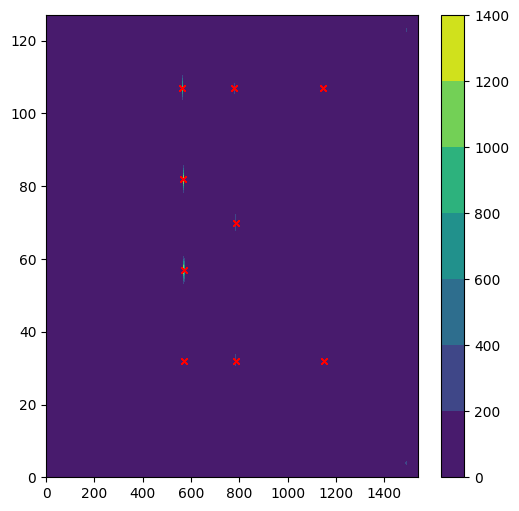

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/31_30.npz', 'peaks': [(72, 226, 228, 229), (20, 218, 220, 221), (32, 224, 226, 227), (58, 228, 230, 231)], 'tube': 1312}


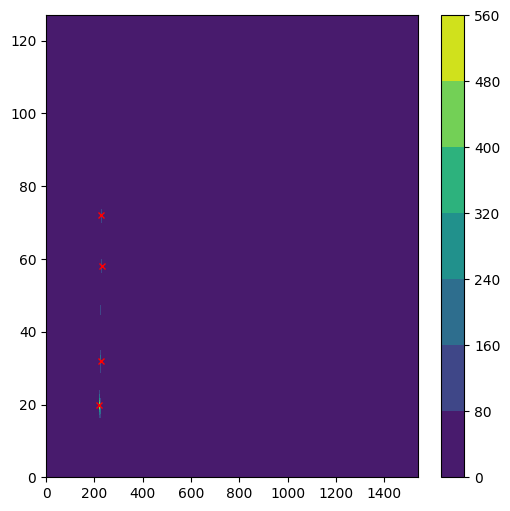

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/10_39.npz', 'peaks': [(3, 456, 457, 458), (13, 673, 674, 677), (74, 673, 674, 678), (84, 457, 458, 459), (84, 457, 458, 459), (13, 673, 674, 677), (74, 673, 674, 678), (3, 456, 457, 458)], 'tube': 1068}


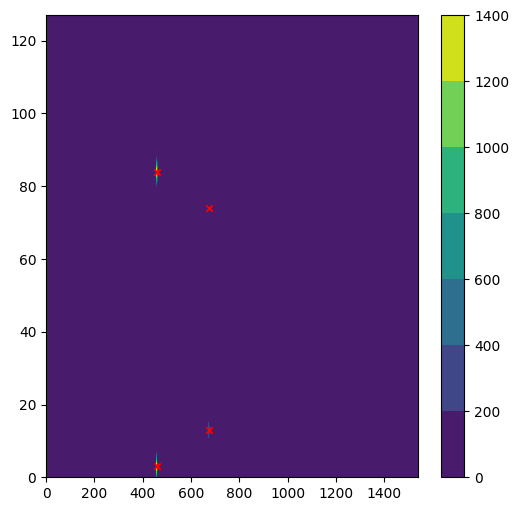

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/67_1.npz', 'peaks': [(14, 302, 306, 308)], 'tube': 143}


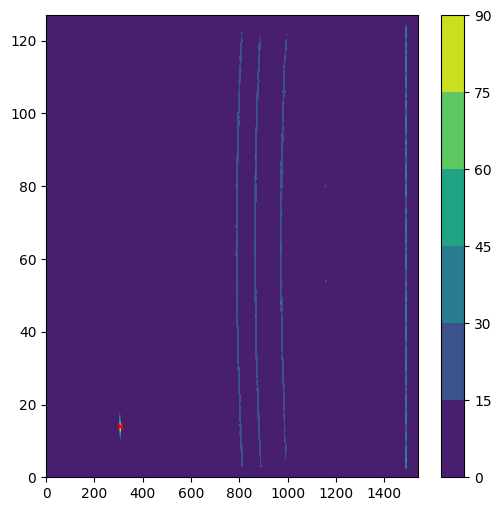

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/67_10.npz', 'peaks': [(24, 314, 316, 317)], 'tube': 258}


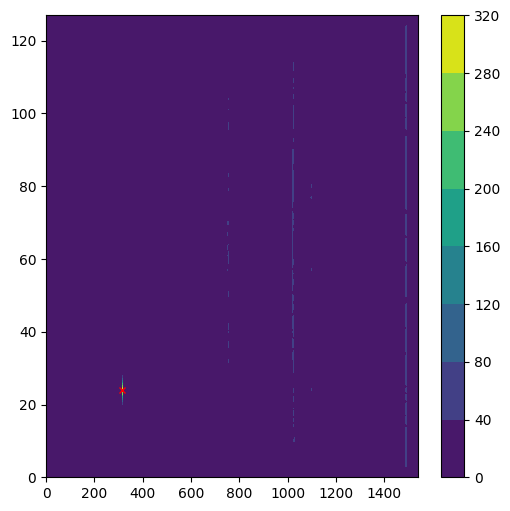

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/57_16.npz', 'peaks': [(8, 639, 640, 643), (37, 641, 642, 645), (66, 641, 642, 645), (37, 641, 642, 645), (8, 639, 640, 643), (66, 641, 642, 645)], 'tube': 725}


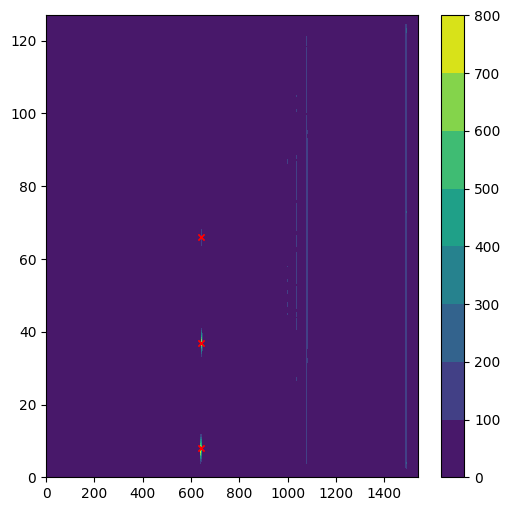

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/47_34.npz', 'peaks': [(100, 226, 230, 232), (35, 212, 217, 219)], 'tube': 1404}


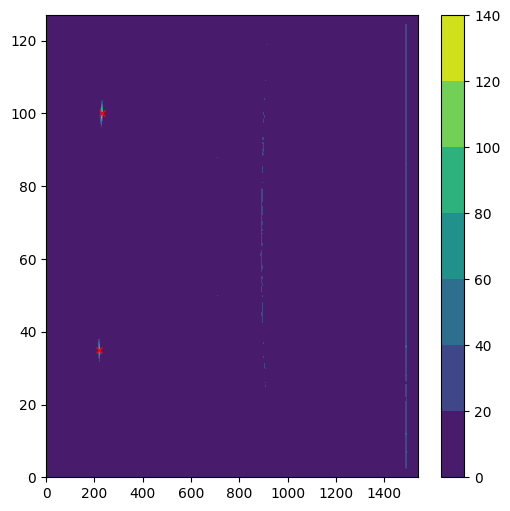

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/6_49.npz', 'peaks': [(113, 1131, 1132, 1135), (113, 764, 765, 769), (113, 549, 550, 552), (113, 764, 765, 769), (113, 1131, 1132, 1135), (113, 549, 550, 552), (113, 549, 550, 552), (113, 1131, 1132, 1135), (113, 764, 765, 769)], 'tube': 880}


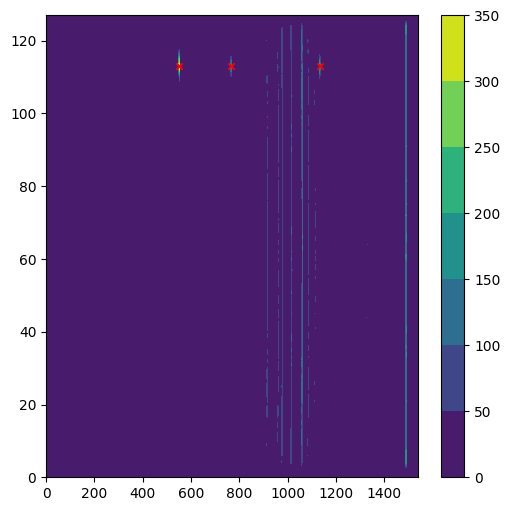

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/18_37.npz', 'peaks': [(100, 292, 294, 295)], 'tube': 1272}


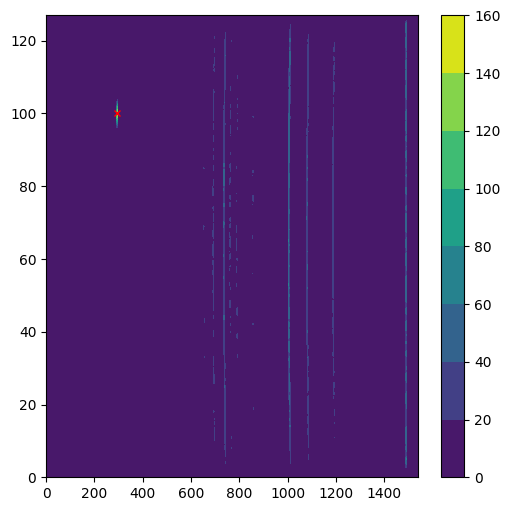

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/10_8.npz', 'peaks': [(0, 574, 575, 578)], 'tube': 290}


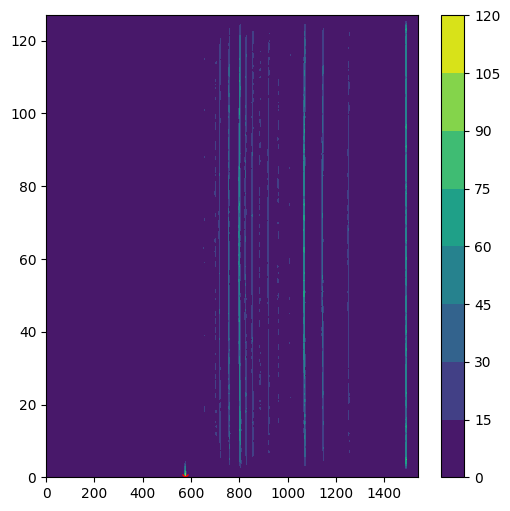

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/43_22.npz', 'peaks': [(122, 612, 613, 616)], 'tube': 624}


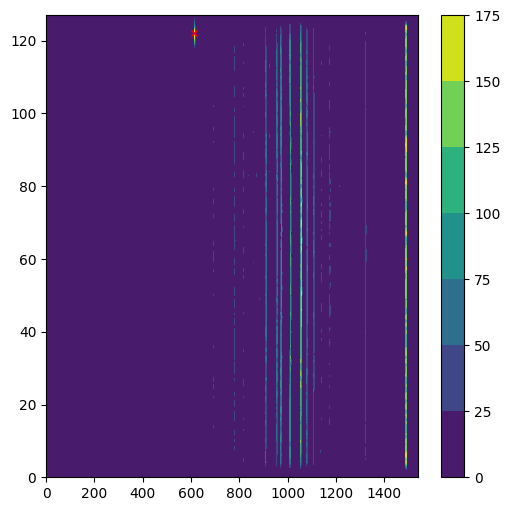

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/36_29.npz', 'peaks': [(51, 375, 376, 377), (34, 371, 372, 374), (68, 376, 377, 379), (34, 586, 587, 591), (60, 590, 591, 596), (34, 953, 954, 959), (68, 376, 377, 379), (34, 371, 372, 374), (51, 375, 376, 377), (34, 586, 587, 591), (60, 590, 591, 596), (34, 953, 954, 959), (60, 590, 591, 596), (34, 371, 372, 374), (51, 375, 376, 377), (68, 376, 377, 379), (34, 586, 587, 591), (34, 953, 954, 959)], 'tube': 1160}


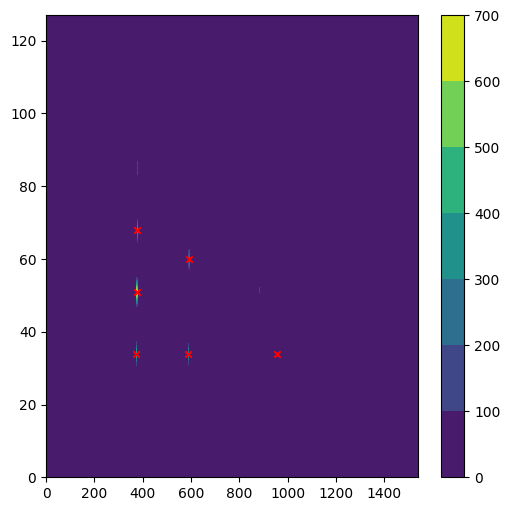

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/19_30.npz', 'peaks': [(43, 229, 230, 231), (31, 226, 228, 229), (56, 228, 230, 231), (56, 228, 230, 231), (31, 226, 228, 229), (43, 229, 230, 231)], 'tube': 1311}


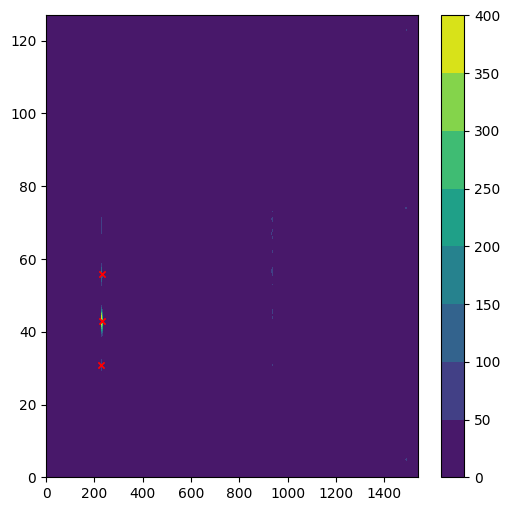

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/66_13.npz', 'peaks': [(123, 231, 232, 233)], 'tube': 214}


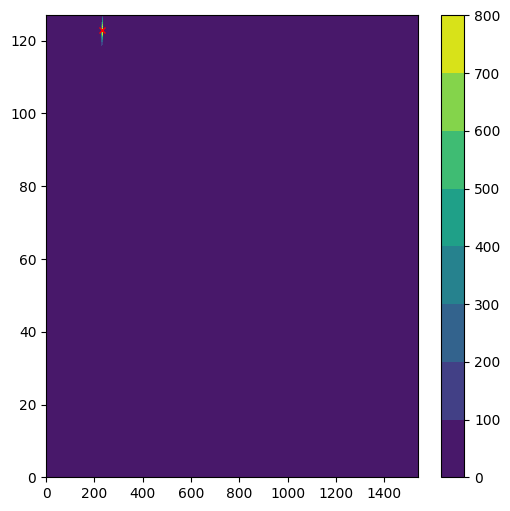

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/42_47.npz', 'peaks': [(65, 533, 534, 536), (88, 533, 534, 537), (88, 533, 534, 537), (65, 533, 534, 536)], 'tube': 1057}


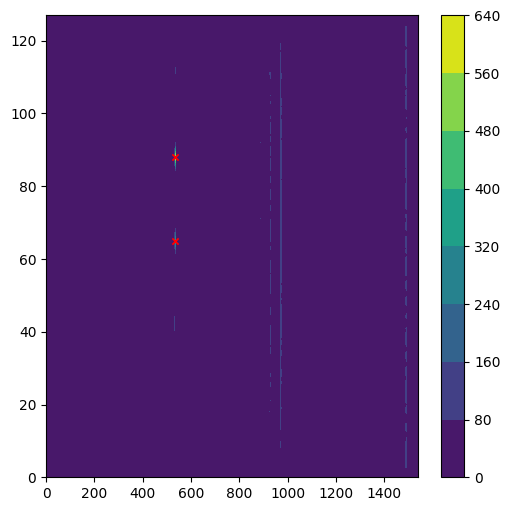

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/45_39.npz', 'peaks': [(51, 633, 634, 637)], 'tube': 838}


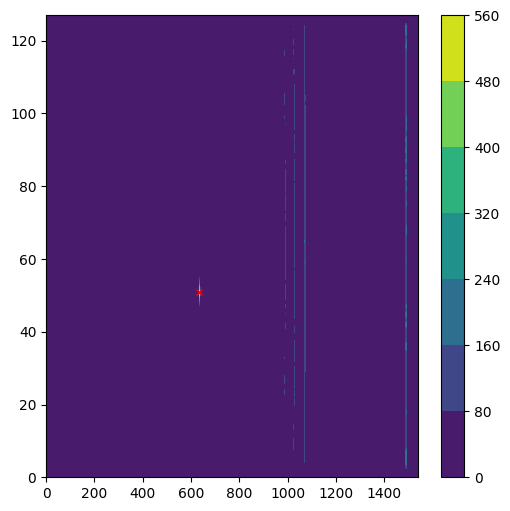

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/44_2.npz', 'peaks': [(33, 457, 458, 462), (53, 458, 460, 464), (73, 453, 454, 458)], 'tube': 210}


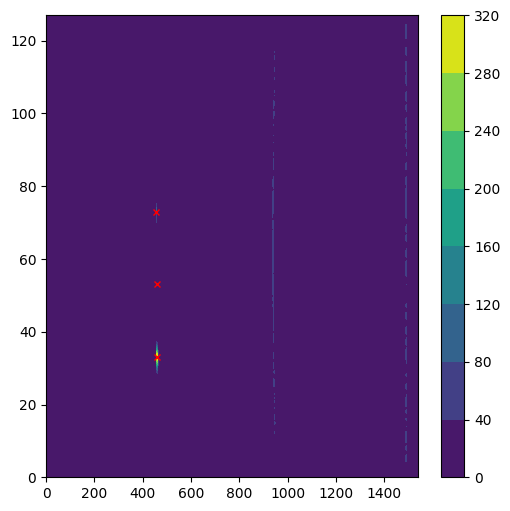

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/5_38.npz', 'peaks': [(1, 780, 781, 785), (40, 1151, 1151, 1155), (40, 784, 784, 789), (14, 567, 568, 570), (40, 569, 570, 572), (14, 567, 568, 570), (40, 1151, 1151, 1155), (1, 780, 781, 785), (40, 784, 784, 789), (40, 569, 570, 572)], 'tube': 827}


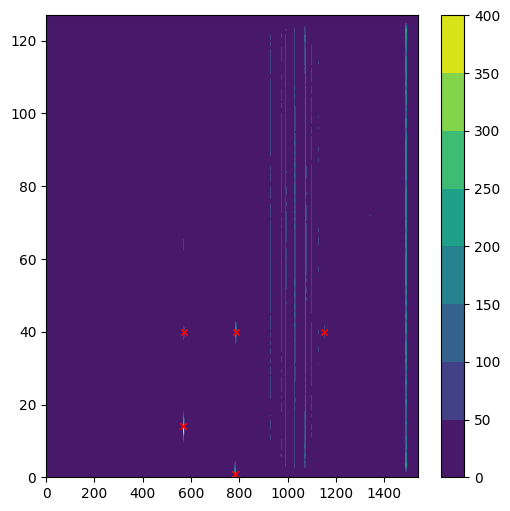

{'nparr_path': '/home/wj1132075/Desktop/CNN_Model_Data/TubeByTubeWithNeighbours/FrameData/48_18.npz', 'peaks': [(97, 556, 557, 559)], 'tube': 500}


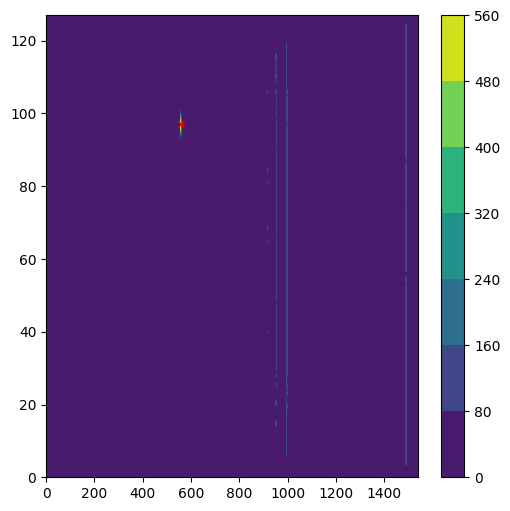

In [14]:
stop = 0
for annot_f_path in tqdm(os.listdir(annotations_output_dir)):
    annot_f_path =  os.path.join(annotations_output_dir,annot_f_path) 
    with open(annot_f_path, 'rb') as handle:
        annot_dict = pickle.load(handle)
        print(annot_dict)
        frame_data = np.load(annot_dict['nparr_path'])['arr_0']
        # print(frame_data.shape)
        plt.figure(figsize=(6,6))
        cs = plt.contourf(frame_data)
        plt.colorbar(cs)
        for x, s, p, e in annot_dict['peaks']:
            plt.plot(p, x, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plt.show()

    stop += 1
    if stop == 20:
        break